## Advisory 
### If you have not yet begun the project 
Please do not use this workspace.  Use the AWS resources provided and the instructions from the [cloud computing lesson](https://classroom.udacity.com/nanodegrees/nd101/parts/b9c4c3c3-b524-427b-8832-9d0748f14a2e/modules/de12f7bf-d980-4998-ab91-0e411184c878/lessons/29df00d8-01c2-4995-92fa-a4afd020be90/concepts/80d2ed46-1bba-413e-891e-610259017251).
### If you have started on this workspace
Please consider downloading your Jupyter notebook and then following the instructions above on using AWS instead.  You can upload your current work to AWS through your GitHub account.  


As a reminder, the project can be found on the [deep learning GitHub page](https://github.com/udacity/deep-learning/tree/master/face_generation).
These warnings are given because the project frequently generates more data than the workspace can handle, causing loading problems and lost work.  Please use [the forums](https://discussions.udacity.com/c/nd101-part-5-GANs/nd101-generate-faces) if you have any questions on the project or its setup.


# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
!pip install -U matplotlib==2.2.2
data_dir = '/data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 12.6MB 55kB/s  eta 0:00:01
Requirement already up-to-date: pyparsing!=2.0.4,!=2.1.2,!=2.1.6,>=2.0.1 in /opt/conda/lib/python3.6/site-packages (from matplotlib==2.2.2)
Requirement already up-to-date: cycler>=0.10 in /opt/conda/lib/python3.6/site-packages/cycler-0.10.0-py3.6.egg (from matplotlib==2.2.2)
    100% |████████████████████████████████| 952kB 766kB/s eta 0:00:01
    100% |████████████████████████████████| 12.2MB 56kB/s  eta 0:00:01
    100% |████████████████████████████████| 215kB 3.2MB/s eta 0:00:01
    100% |████████████████████████████████| 512kB 1.5MB/s eta 0:00:01
Requirement already up-to-date: six>=1.10 in /opt/conda/lib/python3.6/site-packages (from matplotlib==2.2.2)
    100% |████████████████████████████████| 573kB 1.2MB/s eta 0:00:01
  Found existing installation: setuptools 38.4.0
    Uninstalling setuptools-38.4.0:
      Successfully uninstalled setuptools-38.4.0
  Found existing installation: numpy 1.12.1
    Uninstallin

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

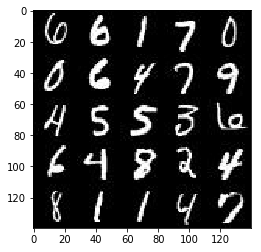

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

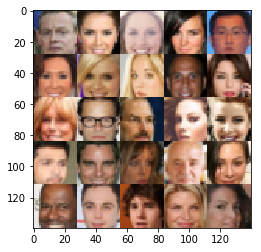

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, lr



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.01
   

    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', activation=None)
        x1 = tf.layers.batch_normalization(x1, training=True)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', activation=None)
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', activation=None)
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        
        flat = tf.reshape(x3, (-1,  4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits




"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.01
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 2*2*512)
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
    
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid', activation=None)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='SAME', activation=None)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
       
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=2, padding='SAME', activation=None)
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    
    d_loss = tf.reduce_mean(d_logits_real - d_logits_fake)
    g_loss = tf.reduce_mean(d_logits_fake)
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    train_vars = tf.trainable_variables()
    d_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    with tf.control_dependencies(update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()
    losses = []
    steps = 0
    total_steps = epoch_count * batch_size
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # TODO: Train Model
                batch_images *= 2 
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
               
                _ = sess.run([d_opt, d_loss], feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run([g_opt, g_loss], feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                
                if steps == 1:
                    print('output inicial:')
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                            "Generator Loss: {:.4f}".format(train_loss_g),
                            "Discriminator Loss: {:.4f}...".format(train_loss_d))
                    losses.append((train_loss_d, train_loss_g))

                    
                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
        
    return losses
                    
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

output inicial:


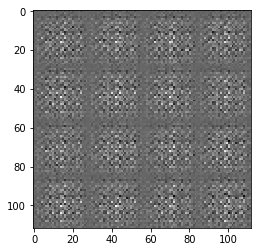

Epoch 1/2... Generator Loss: 16.2742 Discriminator Loss: -33.5752...
Epoch 1/2... Generator Loss: 47.8553 Discriminator Loss: -94.3531...
Epoch 1/2... Generator Loss: 59.9090 Discriminator Loss: -122.7517...
Epoch 1/2... Generator Loss: 58.3353 Discriminator Loss: -132.8601...
Epoch 1/2... Generator Loss: 69.9567 Discriminator Loss: -154.8040...
Epoch 1/2... Generator Loss: -41.5493 Discriminator Loss: -33.1271...
Epoch 1/2... Generator Loss: -15.1375 Discriminator Loss: -42.4278...
Epoch 1/2... Generator Loss: -11.6632 Discriminator Loss: -70.9288...
Epoch 1/2... Generator Loss: 63.2146 Discriminator Loss: -150.6902...
Epoch 1/2... Generator Loss: 91.2670 Discriminator Loss: -181.8577...


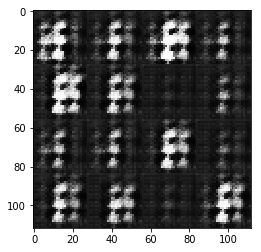

Epoch 1/2... Generator Loss: 111.1324 Discriminator Loss: -218.4580...
Epoch 1/2... Generator Loss: 116.8584 Discriminator Loss: -211.5061...
Epoch 1/2... Generator Loss: 114.5055 Discriminator Loss: -238.8102...
Epoch 1/2... Generator Loss: 130.7223 Discriminator Loss: -213.3792...
Epoch 1/2... Generator Loss: 128.5584 Discriminator Loss: -272.1525...
Epoch 1/2... Generator Loss: 158.0378 Discriminator Loss: -285.1651...
Epoch 1/2... Generator Loss: 90.2014 Discriminator Loss: -246.0816...
Epoch 1/2... Generator Loss: 107.0273 Discriminator Loss: -203.4389...
Epoch 1/2... Generator Loss: -57.0779 Discriminator Loss: -62.4893...
Epoch 1/2... Generator Loss: 108.2975 Discriminator Loss: -256.8375...


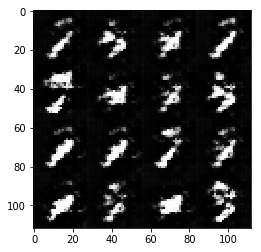

Epoch 1/2... Generator Loss: 174.8717 Discriminator Loss: -232.8111...
Epoch 1/2... Generator Loss: 172.7141 Discriminator Loss: -342.3976...
Epoch 1/2... Generator Loss: 187.4917 Discriminator Loss: -350.5903...
Epoch 1/2... Generator Loss: 219.6919 Discriminator Loss: -395.3328...
Epoch 1/2... Generator Loss: 132.2925 Discriminator Loss: -340.8293...
Epoch 1/2... Generator Loss: 229.7067 Discriminator Loss: -408.9534...
Epoch 1/2... Generator Loss: 249.3971 Discriminator Loss: -326.4122...
Epoch 1/2... Generator Loss: 226.7579 Discriminator Loss: -412.8428...
Epoch 1/2... Generator Loss: 231.3139 Discriminator Loss: -469.7492...
Epoch 1/2... Generator Loss: 260.7313 Discriminator Loss: -514.0208...


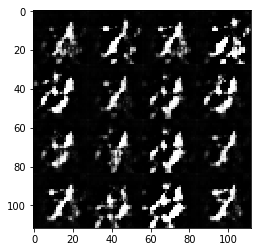

Epoch 1/2... Generator Loss: 269.1628 Discriminator Loss: -485.4591...
Epoch 1/2... Generator Loss: 258.2214 Discriminator Loss: -510.9196...
Epoch 1/2... Generator Loss: 247.3518 Discriminator Loss: -492.5206...
Epoch 1/2... Generator Loss: 335.3672 Discriminator Loss: -364.4982...
Epoch 1/2... Generator Loss: 286.2187 Discriminator Loss: -570.9954...
Epoch 1/2... Generator Loss: 343.2787 Discriminator Loss: -428.3596...
Epoch 1/2... Generator Loss: 338.9913 Discriminator Loss: -602.8403...
Epoch 1/2... Generator Loss: 261.1838 Discriminator Loss: -436.7836...
Epoch 1/2... Generator Loss: 241.2912 Discriminator Loss: -512.5981...
Epoch 1/2... Generator Loss: -148.6297 Discriminator Loss: -65.2784...


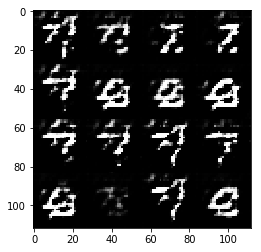

Epoch 1/2... Generator Loss: -1.9439 Discriminator Loss: -377.1461...
Epoch 1/2... Generator Loss: 327.0533 Discriminator Loss: -683.1346...
Epoch 1/2... Generator Loss: -6.1607 Discriminator Loss: -295.7112...
Epoch 1/2... Generator Loss: 301.2839 Discriminator Loss: -581.5892...
Epoch 1/2... Generator Loss: -57.7808 Discriminator Loss: -348.5890...
Epoch 1/2... Generator Loss: 441.2418 Discriminator Loss: -659.4678...
Epoch 2/2... Generator Loss: 359.7738 Discriminator Loss: -562.2726...
Epoch 2/2... Generator Loss: 35.1652 Discriminator Loss: -331.7671...
Epoch 2/2... Generator Loss: 191.9783 Discriminator Loss: -558.0889...
Epoch 2/2... Generator Loss: -39.4272 Discriminator Loss: -328.0034...


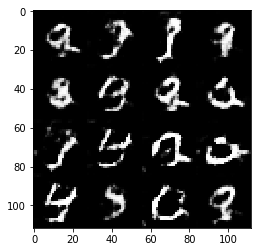

Epoch 2/2... Generator Loss: 391.5651 Discriminator Loss: -667.9760...
Epoch 2/2... Generator Loss: 375.6905 Discriminator Loss: -686.6310...
Epoch 2/2... Generator Loss: 64.1068 Discriminator Loss: -474.2943...
Epoch 2/2... Generator Loss: 95.2721 Discriminator Loss: -473.4214...
Epoch 2/2... Generator Loss: 225.0974 Discriminator Loss: -578.9312...
Epoch 2/2... Generator Loss: 413.8358 Discriminator Loss: -646.1169...
Epoch 2/2... Generator Loss: -104.3466 Discriminator Loss: -396.8196...
Epoch 2/2... Generator Loss: 166.3775 Discriminator Loss: -620.0460...
Epoch 2/2... Generator Loss: -152.5927 Discriminator Loss: -334.8786...
Epoch 2/2... Generator Loss: 136.5947 Discriminator Loss: -506.6922...


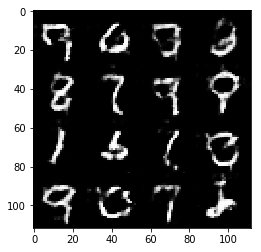

Epoch 2/2... Generator Loss: 551.4047 Discriminator Loss: -565.6838...
Epoch 2/2... Generator Loss: 241.8613 Discriminator Loss: -638.6202...
Epoch 2/2... Generator Loss: 505.4234 Discriminator Loss: -734.5621...
Epoch 2/2... Generator Loss: 155.2157 Discriminator Loss: -545.2085...
Epoch 2/2... Generator Loss: 496.3775 Discriminator Loss: -640.8656...
Epoch 2/2... Generator Loss: 507.8484 Discriminator Loss: -758.0339...
Epoch 2/2... Generator Loss: 191.3375 Discriminator Loss: -619.4386...
Epoch 2/2... Generator Loss: 447.8476 Discriminator Loss: -765.5812...
Epoch 2/2... Generator Loss: 674.2374 Discriminator Loss: -525.7326...
Epoch 2/2... Generator Loss: 538.3055 Discriminator Loss: -697.7917...


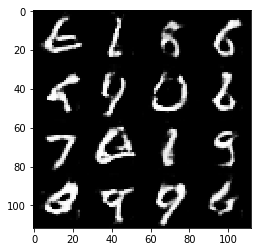

Epoch 2/2... Generator Loss: 680.1130 Discriminator Loss: -611.7439...
Epoch 2/2... Generator Loss: 664.8762 Discriminator Loss: -563.6057...
Epoch 2/2... Generator Loss: 493.6724 Discriminator Loss: -784.6448...
Epoch 2/2... Generator Loss: 360.2922 Discriminator Loss: -754.0264...
Epoch 2/2... Generator Loss: -126.5219 Discriminator Loss: -565.8942...
Epoch 2/2... Generator Loss: 474.7436 Discriminator Loss: -658.4562...
Epoch 2/2... Generator Loss: 350.4103 Discriminator Loss: -894.5087...
Epoch 2/2... Generator Loss: 237.3277 Discriminator Loss: -724.2262...
Epoch 2/2... Generator Loss: 596.1763 Discriminator Loss: -872.1310...
Epoch 2/2... Generator Loss: -175.9481 Discriminator Loss: -678.3875...


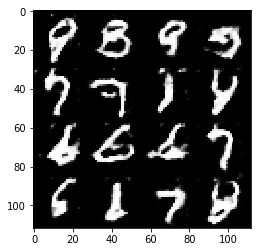

Epoch 2/2... Generator Loss: 635.8313 Discriminator Loss: -537.2893...
Epoch 2/2... Generator Loss: 766.7084 Discriminator Loss: -719.3232...
Epoch 2/2... Generator Loss: 708.2589 Discriminator Loss: -796.2314...
Epoch 2/2... Generator Loss: 641.5724 Discriminator Loss: -784.0320...
Epoch 2/2... Generator Loss: 596.8293 Discriminator Loss: -1125.9257...
Epoch 2/2... Generator Loss: 691.3135 Discriminator Loss: -541.7351...
Epoch 2/2... Generator Loss: -196.6538 Discriminator Loss: -617.2604...
Epoch 2/2... Generator Loss: 679.6531 Discriminator Loss: -776.4679...
Epoch 2/2... Generator Loss: 690.3058 Discriminator Loss: -781.7906...
Epoch 2/2... Generator Loss: 964.0549 Discriminator Loss: -291.2038...


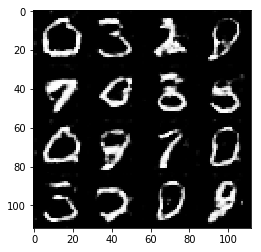

Epoch 2/2... Generator Loss: -211.5575 Discriminator Loss: -689.6986...
Epoch 2/2... Generator Loss: -96.9066 Discriminator Loss: -798.6566...
Epoch 2/2... Generator Loss: 375.4193 Discriminator Loss: -618.1852...


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

output inicial:


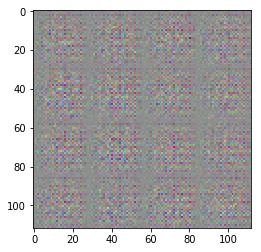

Epoch 1/1... Generator Loss: -5.8607 Discriminator Loss: -12.8433...
Epoch 1/1... Generator Loss: 19.0230 Discriminator Loss: -49.5857...
Epoch 1/1... Generator Loss: 37.7678 Discriminator Loss: -84.7479...
Epoch 1/1... Generator Loss: 41.7631 Discriminator Loss: -99.2902...
Epoch 1/1... Generator Loss: 49.5107 Discriminator Loss: -117.5574...
Epoch 1/1... Generator Loss: 62.6613 Discriminator Loss: -138.5563...
Epoch 1/1... Generator Loss: 71.0954 Discriminator Loss: -156.6696...
Epoch 1/1... Generator Loss: 64.5598 Discriminator Loss: -155.2648...
Epoch 1/1... Generator Loss: -59.7653 Discriminator Loss: -26.4583...
Epoch 1/1... Generator Loss: 2.0334 Discriminator Loss: -89.5120...


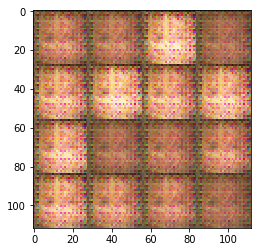

Epoch 1/1... Generator Loss: 60.1549 Discriminator Loss: -154.2398...
Epoch 1/1... Generator Loss: 13.6288 Discriminator Loss: -71.3721...
Epoch 1/1... Generator Loss: 100.2537 Discriminator Loss: -149.9269...
Epoch 1/1... Generator Loss: 15.0166 Discriminator Loss: -51.9271...
Epoch 1/1... Generator Loss: 45.6748 Discriminator Loss: -108.3332...
Epoch 1/1... Generator Loss: 0.0952 Discriminator Loss: -37.6453...
Epoch 1/1... Generator Loss: 99.9060 Discriminator Loss: -126.0055...
Epoch 1/1... Generator Loss: -21.8167 Discriminator Loss: -68.8685...
Epoch 1/1... Generator Loss: 58.3707 Discriminator Loss: -139.0398...
Epoch 1/1... Generator Loss: 47.1154 Discriminator Loss: -63.2503...


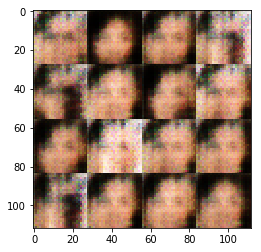

Epoch 1/1... Generator Loss: -93.2978 Discriminator Loss: -15.5382...
Epoch 1/1... Generator Loss: 33.6815 Discriminator Loss: -130.6635...
Epoch 1/1... Generator Loss: 61.4696 Discriminator Loss: -109.0835...
Epoch 1/1... Generator Loss: 32.8039 Discriminator Loss: -48.5222...
Epoch 1/1... Generator Loss: 61.6425 Discriminator Loss: -136.8375...
Epoch 1/1... Generator Loss: 49.3054 Discriminator Loss: -97.9893...
Epoch 1/1... Generator Loss: 39.0810 Discriminator Loss: -162.1207...
Epoch 1/1... Generator Loss: 109.7835 Discriminator Loss: -153.3041...
Epoch 1/1... Generator Loss: 112.8346 Discriminator Loss: -151.3248...
Epoch 1/1... Generator Loss: -115.6767 Discriminator Loss: -2.9843...


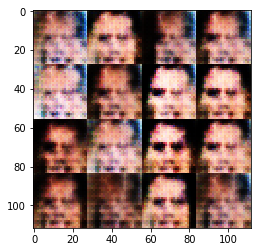

Epoch 1/1... Generator Loss: -60.4246 Discriminator Loss: -57.7304...
Epoch 1/1... Generator Loss: 63.1893 Discriminator Loss: -148.7596...
Epoch 1/1... Generator Loss: 7.5760 Discriminator Loss: -109.8201...
Epoch 1/1... Generator Loss: 15.0742 Discriminator Loss: -86.7515...
Epoch 1/1... Generator Loss: 84.0630 Discriminator Loss: -168.6017...
Epoch 1/1... Generator Loss: 62.5128 Discriminator Loss: -99.7336...
Epoch 1/1... Generator Loss: 42.1713 Discriminator Loss: -88.7957...
Epoch 1/1... Generator Loss: 18.1077 Discriminator Loss: -115.9134...
Epoch 1/1... Generator Loss: 46.3914 Discriminator Loss: -78.3092...
Epoch 1/1... Generator Loss: 120.4127 Discriminator Loss: -106.2799...


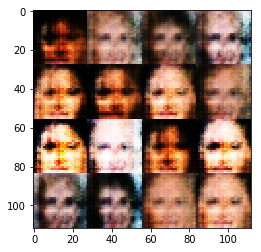

Epoch 1/1... Generator Loss: -14.8892 Discriminator Loss: -109.7750...
Epoch 1/1... Generator Loss: 106.3545 Discriminator Loss: -177.9952...
Epoch 1/1... Generator Loss: 96.3605 Discriminator Loss: -104.5531...
Epoch 1/1... Generator Loss: 30.3728 Discriminator Loss: -129.2487...
Epoch 1/1... Generator Loss: 24.1134 Discriminator Loss: -83.6932...
Epoch 1/1... Generator Loss: 64.1935 Discriminator Loss: -171.9355...
Epoch 1/1... Generator Loss: -70.9144 Discriminator Loss: -83.4615...
Epoch 1/1... Generator Loss: 189.2488 Discriminator Loss: -210.6574...
Epoch 1/1... Generator Loss: 74.1706 Discriminator Loss: -113.9177...
Epoch 1/1... Generator Loss: -88.8228 Discriminator Loss: -88.1552...


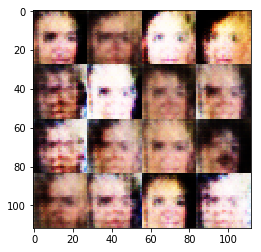

Epoch 1/1... Generator Loss: 105.0283 Discriminator Loss: -155.9038...
Epoch 1/1... Generator Loss: 137.6831 Discriminator Loss: -240.7584...
Epoch 1/1... Generator Loss: 125.4342 Discriminator Loss: -227.1474...
Epoch 1/1... Generator Loss: 95.6221 Discriminator Loss: -144.0086...
Epoch 1/1... Generator Loss: 100.6568 Discriminator Loss: -295.5173...
Epoch 1/1... Generator Loss: 220.4085 Discriminator Loss: -342.2047...
Epoch 1/1... Generator Loss: 240.2019 Discriminator Loss: -277.3568...
Epoch 1/1... Generator Loss: 128.6123 Discriminator Loss: -362.1486...
Epoch 1/1... Generator Loss: 258.4067 Discriminator Loss: -304.6908...
Epoch 1/1... Generator Loss: 306.6269 Discriminator Loss: -268.8842...


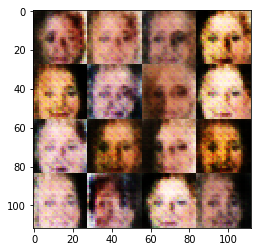

Epoch 1/1... Generator Loss: 154.8246 Discriminator Loss: -401.0175...
Epoch 1/1... Generator Loss: 101.8916 Discriminator Loss: -262.3655...
Epoch 1/1... Generator Loss: 273.4961 Discriminator Loss: -390.1090...
Epoch 1/1... Generator Loss: 351.4109 Discriminator Loss: -735.7985...
Epoch 1/1... Generator Loss: -358.9061 Discriminator Loss: 26.5717...
Epoch 1/1... Generator Loss: -199.3175 Discriminator Loss: -60.7039...
Epoch 1/1... Generator Loss: 305.4778 Discriminator Loss: -276.3546...
Epoch 1/1... Generator Loss: 233.4500 Discriminator Loss: -293.3480...
Epoch 1/1... Generator Loss: 218.0495 Discriminator Loss: -616.6647...
Epoch 1/1... Generator Loss: 397.3524 Discriminator Loss: -633.6650...


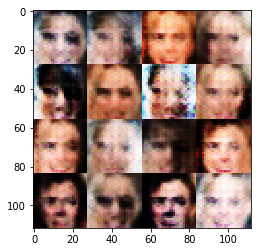

Epoch 1/1... Generator Loss: 398.5942 Discriminator Loss: -795.7133...
Epoch 1/1... Generator Loss: -9.3095 Discriminator Loss: -414.9566...
Epoch 1/1... Generator Loss: 148.7301 Discriminator Loss: -345.9388...
Epoch 1/1... Generator Loss: -460.4400 Discriminator Loss: 22.7573...
Epoch 1/1... Generator Loss: -427.8862 Discriminator Loss: -28.1053...
Epoch 1/1... Generator Loss: -352.7030 Discriminator Loss: -39.1410...
Epoch 1/1... Generator Loss: 103.9135 Discriminator Loss: -273.2132...
Epoch 1/1... Generator Loss: 93.3272 Discriminator Loss: -334.5916...
Epoch 1/1... Generator Loss: 49.2830 Discriminator Loss: -178.9055...
Epoch 1/1... Generator Loss: 73.0696 Discriminator Loss: -256.1842...


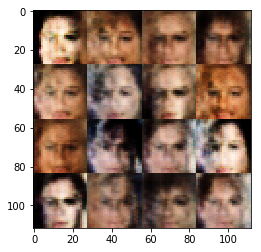

Epoch 1/1... Generator Loss: 142.9492 Discriminator Loss: -268.9553...
Epoch 1/1... Generator Loss: 248.3100 Discriminator Loss: -378.7003...
Epoch 1/1... Generator Loss: 80.8251 Discriminator Loss: -259.1852...
Epoch 1/1... Generator Loss: 127.9407 Discriminator Loss: -201.5881...
Epoch 1/1... Generator Loss: 177.9216 Discriminator Loss: -227.3422...
Epoch 1/1... Generator Loss: 87.5365 Discriminator Loss: -196.1022...
Epoch 1/1... Generator Loss: 4.0387 Discriminator Loss: -253.9857...
Epoch 1/1... Generator Loss: 143.1282 Discriminator Loss: -310.3597...
Epoch 1/1... Generator Loss: -9.3562 Discriminator Loss: -262.9468...
Epoch 1/1... Generator Loss: -231.1443 Discriminator Loss: -40.5739...


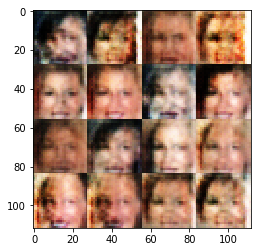

Epoch 1/1... Generator Loss: 27.3743 Discriminator Loss: -346.0234...
Epoch 1/1... Generator Loss: 37.7005 Discriminator Loss: -238.7047...
Epoch 1/1... Generator Loss: 18.0890 Discriminator Loss: -211.8517...
Epoch 1/1... Generator Loss: 173.0680 Discriminator Loss: -284.9532...
Epoch 1/1... Generator Loss: 4.6052 Discriminator Loss: -325.2413...
Epoch 1/1... Generator Loss: -452.2728 Discriminator Loss: 5.2082...
Epoch 1/1... Generator Loss: -330.7256 Discriminator Loss: -80.8373...
Epoch 1/1... Generator Loss: 306.3262 Discriminator Loss: -630.5550...
Epoch 1/1... Generator Loss: 1.1045 Discriminator Loss: -253.4461...
Epoch 1/1... Generator Loss: -142.2201 Discriminator Loss: -118.1743...


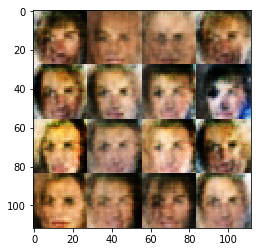

Epoch 1/1... Generator Loss: -77.8613 Discriminator Loss: -213.9769...
Epoch 1/1... Generator Loss: 9.0316 Discriminator Loss: -327.0292...
Epoch 1/1... Generator Loss: 290.5713 Discriminator Loss: -410.5173...
Epoch 1/1... Generator Loss: 46.0350 Discriminator Loss: -292.4674...
Epoch 1/1... Generator Loss: 25.5976 Discriminator Loss: -293.3696...
Epoch 1/1... Generator Loss: -491.7044 Discriminator Loss: -47.6345...
Epoch 1/1... Generator Loss: -205.3000 Discriminator Loss: -85.5114...
Epoch 1/1... Generator Loss: -104.1143 Discriminator Loss: -177.1888...
Epoch 1/1... Generator Loss: 167.0728 Discriminator Loss: -598.2652...
Epoch 1/1... Generator Loss: -136.9666 Discriminator Loss: -175.8954...


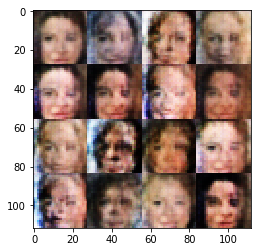

Epoch 1/1... Generator Loss: 173.6806 Discriminator Loss: -279.4370...
Epoch 1/1... Generator Loss: 46.9911 Discriminator Loss: -252.0413...
Epoch 1/1... Generator Loss: 200.7617 Discriminator Loss: -200.6358...
Epoch 1/1... Generator Loss: 229.2766 Discriminator Loss: -316.2913...
Epoch 1/1... Generator Loss: 123.1681 Discriminator Loss: -350.8465...
Epoch 1/1... Generator Loss: 28.1342 Discriminator Loss: -224.7914...
Epoch 1/1... Generator Loss: -55.5056 Discriminator Loss: -156.9680...
Epoch 1/1... Generator Loss: -100.6556 Discriminator Loss: -357.5137...
Epoch 1/1... Generator Loss: 237.5651 Discriminator Loss: -264.7388...
Epoch 1/1... Generator Loss: 197.4711 Discriminator Loss: -327.2690...


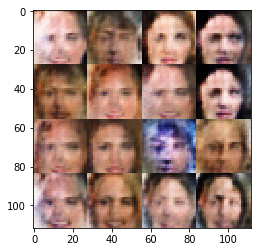

Epoch 1/1... Generator Loss: 32.6177 Discriminator Loss: -279.3892...
Epoch 1/1... Generator Loss: -419.0383 Discriminator Loss: 2.2522...
Epoch 1/1... Generator Loss: -139.0416 Discriminator Loss: -88.1998...
Epoch 1/1... Generator Loss: 383.7465 Discriminator Loss: -525.2930...
Epoch 1/1... Generator Loss: -64.3657 Discriminator Loss: -296.6627...
Epoch 1/1... Generator Loss: -545.1568 Discriminator Loss: 56.4214...
Epoch 1/1... Generator Loss: -154.4795 Discriminator Loss: -223.8649...
Epoch 1/1... Generator Loss: -53.1119 Discriminator Loss: -398.3190...
Epoch 1/1... Generator Loss: 584.4642 Discriminator Loss: -598.6370...
Epoch 1/1... Generator Loss: 266.1003 Discriminator Loss: -346.2744...


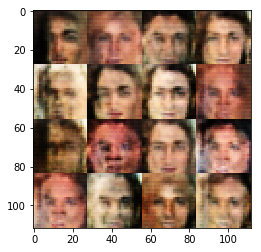

Epoch 1/1... Generator Loss: 444.6364 Discriminator Loss: -551.0059...
Epoch 1/1... Generator Loss: 443.0309 Discriminator Loss: -537.3789...
Epoch 1/1... Generator Loss: -254.6716 Discriminator Loss: -31.2264...
Epoch 1/1... Generator Loss: -40.1252 Discriminator Loss: -291.9847...
Epoch 1/1... Generator Loss: 106.8794 Discriminator Loss: -311.1959...
Epoch 1/1... Generator Loss: 46.3340 Discriminator Loss: -164.3120...
Epoch 1/1... Generator Loss: 56.6995 Discriminator Loss: -300.2157...
Epoch 1/1... Generator Loss: 63.3483 Discriminator Loss: -387.7102...
Epoch 1/1... Generator Loss: -153.3945 Discriminator Loss: -282.8087...
Epoch 1/1... Generator Loss: 85.0919 Discriminator Loss: -219.4566...


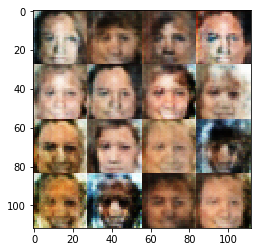

Epoch 1/1... Generator Loss: 1.1610 Discriminator Loss: -247.5758...
Epoch 1/1... Generator Loss: 203.2539 Discriminator Loss: -593.0792...
Epoch 1/1... Generator Loss: 195.6217 Discriminator Loss: -412.5000...
Epoch 1/1... Generator Loss: 216.1516 Discriminator Loss: -433.0811...
Epoch 1/1... Generator Loss: 13.3821 Discriminator Loss: -419.4547...
Epoch 1/1... Generator Loss: 170.8415 Discriminator Loss: -320.7252...
Epoch 1/1... Generator Loss: -98.9109 Discriminator Loss: -146.8828...
Epoch 1/1... Generator Loss: 114.8914 Discriminator Loss: -371.9559...
Epoch 1/1... Generator Loss: 9.5024 Discriminator Loss: -431.3962...
Epoch 1/1... Generator Loss: 3.3602 Discriminator Loss: -156.4555...


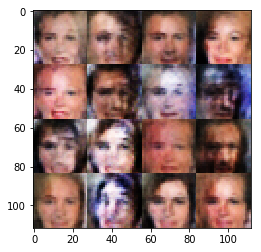

Epoch 1/1... Generator Loss: -13.2897 Discriminator Loss: -225.9075...
Epoch 1/1... Generator Loss: 210.6156 Discriminator Loss: -391.4130...
Epoch 1/1... Generator Loss: 88.2302 Discriminator Loss: -331.3268...
Epoch 1/1... Generator Loss: 221.9043 Discriminator Loss: -313.1332...
Epoch 1/1... Generator Loss: 224.7255 Discriminator Loss: -335.4969...
Epoch 1/1... Generator Loss: 208.5603 Discriminator Loss: -470.9823...
Epoch 1/1... Generator Loss: -282.7659 Discriminator Loss: 45.6264...
Epoch 1/1... Generator Loss: 164.2051 Discriminator Loss: -567.8302...
Epoch 1/1... Generator Loss: 127.3771 Discriminator Loss: -259.2032...
Epoch 1/1... Generator Loss: -101.5591 Discriminator Loss: -176.0030...


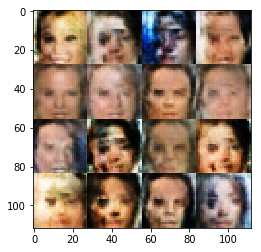

Epoch 1/1... Generator Loss: 42.4544 Discriminator Loss: -185.0478...
Epoch 1/1... Generator Loss: 132.6707 Discriminator Loss: -235.6036...
Epoch 1/1... Generator Loss: 207.4447 Discriminator Loss: -332.9255...
Epoch 1/1... Generator Loss: 23.3166 Discriminator Loss: -217.5864...
Epoch 1/1... Generator Loss: -44.8897 Discriminator Loss: -465.7815...
Epoch 1/1... Generator Loss: 24.6384 Discriminator Loss: -175.4532...
Epoch 1/1... Generator Loss: -87.8400 Discriminator Loss: 2.1380...
Epoch 1/1... Generator Loss: 151.6467 Discriminator Loss: -396.8475...
Epoch 1/1... Generator Loss: 186.8620 Discriminator Loss: -316.3663...
Epoch 1/1... Generator Loss: 240.0844 Discriminator Loss: -363.6573...


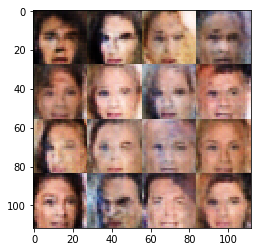

Epoch 1/1... Generator Loss: 97.8909 Discriminator Loss: -353.4081...
Epoch 1/1... Generator Loss: 181.7838 Discriminator Loss: -234.3761...
Epoch 1/1... Generator Loss: 480.2831 Discriminator Loss: -526.4164...
Epoch 1/1... Generator Loss: -20.4721 Discriminator Loss: -244.2154...
Epoch 1/1... Generator Loss: -245.5867 Discriminator Loss: -77.8921...
Epoch 1/1... Generator Loss: 27.1338 Discriminator Loss: -356.9247...
Epoch 1/1... Generator Loss: 294.2992 Discriminator Loss: -505.0867...
Epoch 1/1... Generator Loss: 330.5349 Discriminator Loss: -503.0245...
Epoch 1/1... Generator Loss: 12.6000 Discriminator Loss: -223.2385...
Epoch 1/1... Generator Loss: -9.8536 Discriminator Loss: -159.2793...


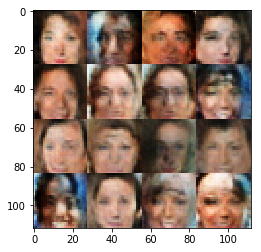

Epoch 1/1... Generator Loss: 102.4891 Discriminator Loss: -184.5894...
Epoch 1/1... Generator Loss: 161.1620 Discriminator Loss: -429.7510...
Epoch 1/1... Generator Loss: -131.4692 Discriminator Loss: -78.2185...
Epoch 1/1... Generator Loss: 38.1497 Discriminator Loss: -324.7928...
Epoch 1/1... Generator Loss: 106.9799 Discriminator Loss: -508.5010...
Epoch 1/1... Generator Loss: -148.1462 Discriminator Loss: -112.9373...
Epoch 1/1... Generator Loss: 78.6660 Discriminator Loss: -420.8354...
Epoch 1/1... Generator Loss: 78.9914 Discriminator Loss: -309.9722...
Epoch 1/1... Generator Loss: 343.9717 Discriminator Loss: -429.2786...
Epoch 1/1... Generator Loss: 119.4433 Discriminator Loss: -213.9594...


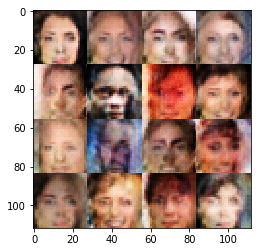

Epoch 1/1... Generator Loss: -339.0032 Discriminator Loss: -25.4962...
Epoch 1/1... Generator Loss: 21.8196 Discriminator Loss: -326.8385...
Epoch 1/1... Generator Loss: 254.2323 Discriminator Loss: -386.5017...
Epoch 1/1... Generator Loss: -193.8629 Discriminator Loss: -171.7793...
Epoch 1/1... Generator Loss: 272.5753 Discriminator Loss: -292.3995...
Epoch 1/1... Generator Loss: 41.0449 Discriminator Loss: -220.0742...
Epoch 1/1... Generator Loss: 109.5282 Discriminator Loss: -386.4837...
Epoch 1/1... Generator Loss: 164.3011 Discriminator Loss: -404.9452...
Epoch 1/1... Generator Loss: 233.1979 Discriminator Loss: -415.3088...
Epoch 1/1... Generator Loss: 134.8664 Discriminator Loss: -338.8898...


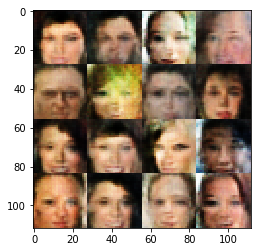

Epoch 1/1... Generator Loss: -7.1049 Discriminator Loss: -393.5873...
Epoch 1/1... Generator Loss: -8.5209 Discriminator Loss: -266.8240...
Epoch 1/1... Generator Loss: -37.4012 Discriminator Loss: -436.1285...
Epoch 1/1... Generator Loss: 97.1287 Discriminator Loss: -267.8226...
Epoch 1/1... Generator Loss: 163.1493 Discriminator Loss: -359.7967...
Epoch 1/1... Generator Loss: 223.7852 Discriminator Loss: -405.7405...
Epoch 1/1... Generator Loss: -108.5846 Discriminator Loss: -347.6335...
Epoch 1/1... Generator Loss: 46.6540 Discriminator Loss: -338.2423...
Epoch 1/1... Generator Loss: 240.4183 Discriminator Loss: -509.7437...
Epoch 1/1... Generator Loss: 242.2685 Discriminator Loss: -541.2423...


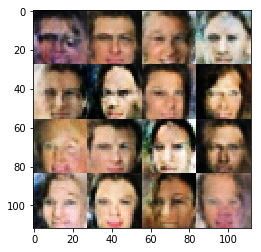

Epoch 1/1... Generator Loss: -234.8826 Discriminator Loss: -116.6568...
Epoch 1/1... Generator Loss: 354.5704 Discriminator Loss: -630.0468...
Epoch 1/1... Generator Loss: 78.7954 Discriminator Loss: -324.0143...
Epoch 1/1... Generator Loss: 159.2621 Discriminator Loss: -391.7280...
Epoch 1/1... Generator Loss: 104.3807 Discriminator Loss: -207.5800...
Epoch 1/1... Generator Loss: 163.1752 Discriminator Loss: -558.8020...
Epoch 1/1... Generator Loss: 91.3429 Discriminator Loss: -284.7249...
Epoch 1/1... Generator Loss: 466.4503 Discriminator Loss: -338.5433...
Epoch 1/1... Generator Loss: 250.2976 Discriminator Loss: -427.3749...
Epoch 1/1... Generator Loss: -38.6789 Discriminator Loss: -161.8083...


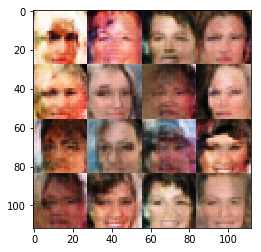

Epoch 1/1... Generator Loss: 143.1852 Discriminator Loss: -333.6623...
Epoch 1/1... Generator Loss: -137.0590 Discriminator Loss: -153.3086...
Epoch 1/1... Generator Loss: 310.9105 Discriminator Loss: -456.2248...
Epoch 1/1... Generator Loss: 208.5265 Discriminator Loss: -379.2971...
Epoch 1/1... Generator Loss: 141.1921 Discriminator Loss: -208.2690...
Epoch 1/1... Generator Loss: 304.5587 Discriminator Loss: -408.4953...
Epoch 1/1... Generator Loss: -116.5761 Discriminator Loss: -64.0254...
Epoch 1/1... Generator Loss: 71.1404 Discriminator Loss: -331.7745...
Epoch 1/1... Generator Loss: 171.4808 Discriminator Loss: -444.2418...
Epoch 1/1... Generator Loss: 258.6957 Discriminator Loss: -288.5984...


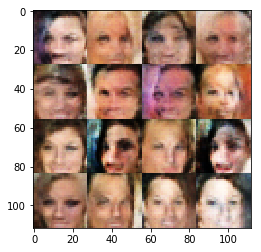

Epoch 1/1... Generator Loss: 41.8124 Discriminator Loss: -226.3442...
Epoch 1/1... Generator Loss: 208.1004 Discriminator Loss: -185.1466...
Epoch 1/1... Generator Loss: -157.6432 Discriminator Loss: -17.8453...
Epoch 1/1... Generator Loss: 47.0400 Discriminator Loss: -289.1015...
Epoch 1/1... Generator Loss: 31.9853 Discriminator Loss: -423.4993...
Epoch 1/1... Generator Loss: -84.6922 Discriminator Loss: -283.2475...
Epoch 1/1... Generator Loss: -65.8579 Discriminator Loss: -269.8808...
Epoch 1/1... Generator Loss: 359.8470 Discriminator Loss: -280.7639...
Epoch 1/1... Generator Loss: 70.8973 Discriminator Loss: -420.3911...


In [ ]:
batch_size = 84
z_dim = 100
learning_rate = 0.0003
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.